# Parsing multiple KinExA activity logs.
The KinExA software can export an analysis file for a completed experiment (as a TSV file).  This script operates on a master folder, which itself contains sub-folders each with several TSV files.  Into each of these sub-folders, the script creates an Excel file with the relevant values from all its files, and a graphical summary of the results.

In [596]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib as mpl
import glob
import os
import math

# We'll make sure to display the full dataframe, so we're not confused about its nature and contents.
pd.set_option('display.expand_frame_repr', False)
pd.set_option("display.max_rows", None)

First, figure out the path for your current directory so that you may copy it into later cells.

In [597]:
os.getcwd()

'/Users/DanielMA/Root/Hinge/Data analysis/Sandbox'

Second, switch to the folder that contains the folders of TSV files to be parsed.

In [598]:
os.chdir("/Users/DanielMA/Root/Hinge/Data analysis/Sandbox")
os.getcwd()

'/Users/DanielMA/Root/Hinge/Data analysis/Sandbox'

There's a few functions that will make our life easier.

In [615]:
def dataframes_from_TSVs(path):
    """ Accepts a path for a system folder containing the required TSV files, and returns
    two dataframes.  The first contains ALL information from those TSV files.  The second contains only 
    several columns that we define to be useful.  The TSV files in question are the exported activity files 
    from KinExA experiments.  No nCurves, just experiments."""
    
    file_names = glob.glob(path+"/*.tsv")
    file_names.sort()  # Because the list of files out of glob.glob isn't alphabetical.
    short_names = []
    long = pd.DataFrame()
    
    list_ = []
    for name in file_names:    
        df = pd.read_csv(name,index_col=None, header=0, sep='\t')

        # I also added a new column to each entry that contains the filename, in case it's different
        # from the name listed in the experimental file itself.
        short_name = name.replace(path+'/','')
        short_name = short_name.replace('.tsv','')
        short_names.append(short_name)
        df['File Name'] = short_name
        list_.append(df)
    long = pd.concat(list_,axis=1,keys=short_names)
    
    # Here's where we determine the particular columns that will go into the short output.
    list_ = []
    for i in short_names:
        list_.append(long[i].loc[0,['File Name','Experiment Name','Kd','CBP Molecular Concentration','Kd High', 
                                                   'Kd Low','%Error','Ratio','CBP %Activity','Sig100','NSB',
                                                   'Analysis Type','Comments']])
    short = pd.concat(list_, axis=1, keys=short_names)
    
    return (long, short)



def export_df_to_Excel(df, path):
    """ Takes a dataframe of results and a system path, and returns an Excel file of those results to that path."""
    writer = pd.ExcelWriter(path+'/Table.xlsx')
    df.to_excel(writer,'Sheet1')
    writer.save()


    
def plot_Kd(results, path):
    """ Takes a dataframe of results (expecting the structure of the abridged dataframe from the function
    dataframes_from_TSVs, as well as a system path.  The function displays and saves a log plot with those 
    experimental results all together."""
    
    plt.clf

    # The parameters for the bars are extracted from the same Results dataframe that we exported to Excel.
    labels = results.loc['File Name']
    kd_hi = results.loc['Kd High']
    kd_lo = results.loc['Kd Low']
    bar_height = kd_hi.sub(kd_lo)
    error1 = results.loc['%Error']
    kd1 = results.loc['Kd']
    cbp1 = results.loc['CBP Molecular Concentration']
    
    
    ind = np.arange(len(results.columns))

    # The color scheme ranges from blue (low error) to red (high error), with the scale centered at 3.0 (white).
    cmap = mpl.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=1, vmax=5)  #Extreme values beyond this take the full red or blue color.
    color_final = cmx.ScalarMappable(norm=norm, cmap=cmap).to_rgba(pd.to_numeric(error1))

    
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
    fig, ax1 = plt.subplots(figsize=(15, 10))

    ax1.barh(ind, bar_height,left=kd_lo, align='center', color=color_final, edgecolor='k', linewidth=1)

    x_min = 1e-13
    x_max = 1e-8
    y_min = -0.5
    y_max = len(results.columns)-0.5


    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(y_min,y_max)
    ax1.set_xscale('log')

    ax1.vlines(1e-9,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 nM.
    ax1.vlines(1e-12,-0.5,len(results.columns), linewidth=3)  #Vertical line at 1 pM
    ax1.grid(which="major", axis='x', color='k', linestyle='--', linewidth=0.5)
    ax1.grid(which="minor", axis='x', color='b', linestyle='-', linewidth=0.1)
    ax1.tick_params(top=True, labeltop=True)

    ax1.hlines(ind+0.5, x_min, x_max, linestyle='--', linewidth=0.5)

    # Red lines mark the Kd prediction for each bar.  Green lines mark the CBP concentration for that run.
    ax1.vlines(kd1,ind-0.5,ind+0.5, linewidth=3, color='r')  #Vertical line at 1 pM
    ax1.vlines(cbp1,ind-0.5,ind+0.5, linewidth=5, color='b')  #Vertical line at 1 pM

    ax1.set_xticklabels(['','100 fM','1 pM','10 pM','100 pM','1 nM','10 nM'])
    ax1.set_yticks(ind)
    ax1.set_yticklabels(labels)
    ax1.tick_params(axis='y',length=0)
    ax1.invert_yaxis()
    
    data_for_table = results.loc[['File Name','Kd','%Error','CBP %Activity','Ratio']]
    col_labels=['File Name','Kd','% Error','% CBP','Ratio']

    file_names = results.loc['File Name'].values.tolist()
    kd2 = ["{0:.0f}".format(x) for x in data_for_table.loc['Kd'].values / 1e-12]
    error2 = ["{0:.2f}".format(x) for x in data_for_table.loc['%Error'].values]
    cbp2 = ["{0:.0f}".format(round(x,0)) for x in data_for_table.loc['CBP %Activity'].values]
    ratio2 = ["{0:.3f}".format(round(x,3)) for x in data_for_table.loc['Ratio'].values]

    cell_text = np.array([file_names, kd2, error2, cbp2, ratio2]).T.tolist()
    col_widths = [1]+[0.5]*4
    
    the_table = ax1.table(cellText=cell_text, cellColours=None,
      cellLoc='center', colWidths=col_widths,
      rowLabels=None, rowColours=None, rowLoc='left',
      colLabels=col_labels, colColours=None, colLoc='center',
      loc='center', bbox=[0.0, -0.6, 1.0, 0.5])
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize (10)

    
    plt.savefig(path+'/Graph.png',bbox_inches='tight')  # Comment to avoid saving it over and over.
    plt.show()

We're testing folder: /Users/DanielMA/Root/Hinge/Data analysis/Sandbox/Y1


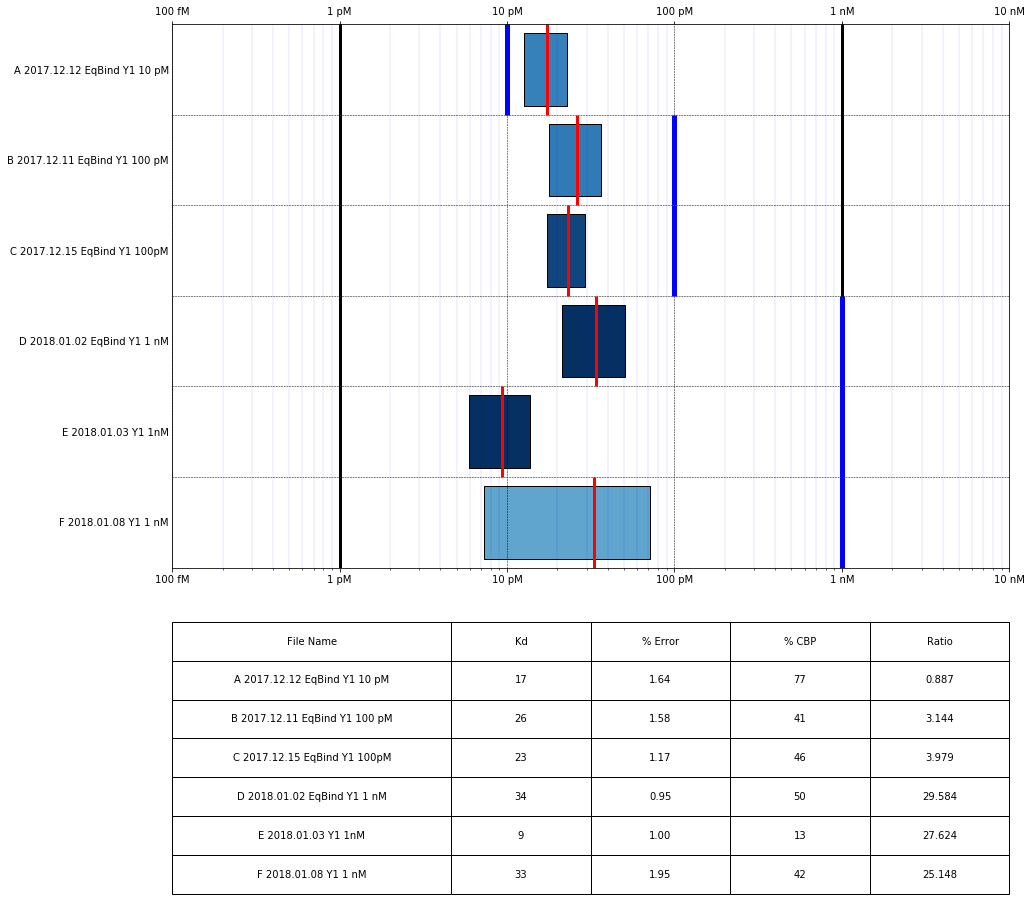

In [616]:
folder_names = [os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]
folder_paths = glob.glob(os.getcwd()+'/*')

# Let's test this bitch.
test_folder = folder_paths[0]
print("We're testing folder: "+test_folder)

# Turn TSV files from that folder into dataframes
long, short = dataframes_from_TSVs(test_folder)

# Export the abridged dataframe to Excel in the same folder
export_df_to_Excel(short, test_folder)

# # Plot the abridged dataframe
plot_Kd(short, test_folder)